In [1]:
import sys
sys.path.append('../src')

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf

In [3]:
from gait.config import pd
from gait.utils import get_data_by_overlap_percent,get_overlap_data_all_sessions,  split_test_train_by_subjects, remove_invalid_data, get_overlap_data_all_sessions
from gait.training import train_model_with_stats
from gait.evalution import save_history, save_test_history, save_accuracy_loss_figure, save_confusion_matrix_figure, compute_validations_predictions,compute_validations_predictions_with_stats


In [4]:
def compute_resultant_acceleration(X):
    return np.sqrt(X[:,:,0] **2 + X[:,:,1] ** 2 + X[:,:,2] ** 2)

def compute_resultant_gyro(X):
    return np.sqrt(X[:,:,3] **2 + X[:,:,4] ** 2 + X[:,:,5] ** 2)

def compute_resultant_angle(X):
    return np.sqrt(X[:,:,6] **2 + X[:,:,7] ** 2 + X[:,:,8] ** 2)

In [5]:
def get_std_values(X, channel):
    return X[:, :, channel].std(axis=1)


def get_mean_values(X, channel):
    return X[:, :, channel].mean(axis=1)


def get_max_values(X, channel):
    return X[:, :, channel].max(axis=1)


def get_statistic_feature_all_channels(X):
    statistic_features = []
    print(X_train.shape)
    for channel in range(9,12):
        value = get_std_values(X, channel)
        print('value shape', value.shape)
        statistic_features.append(value)
        statistic_features.append(get_mean_values(X, channel))
        statistic_features.append(get_max_values(X, channel))

    return np.vstack(statistic_features).T

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
y_train shape (62851, 6)
(62851, 128, 12)
value shape (62851,)
value shape (62851,)
value shape (62851,)
(62851, 128, 12)
value shape (2903,)
value shape (2903,)
value shape (2903,)
(62851, 9)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:

/home/sanjeev/.local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
393/393 [==============================] - 25s 51ms/step - loss: 4.9433 - accuracy: 0.4465 - val_loss: 0.9816 - val_accuracy: 0.6066
Epoch 2/50
393/393 [==============================] - 18s 46ms/step - loss: 1.0788 - accuracy: 0.5490 - val_loss: 0.9260 - val_accuracy: 0.6267
Epoch 3/50
393/393 [==============================] - 18s 46ms/step - loss: 0.9905 - accuracy: 0.5948 - val_loss: 0.7906 - val_accuracy: 0.6914
Epoch 4/50
393/393 [==============================] - 18s 45ms/step - loss: 0.9338 - accuracy: 0.6162 - val_loss: 0.8208 - val_accuracy: 0.6888
Epoch 5/50
393/393 [==============================] - 18s 45ms/step - loss: 0.8988 - accuracy: 0.6316 - val_loss: 0.8526 - val_accuracy: 0.6703
Epoch 6/50
393/393 [==============================] - 18s 46ms/step - loss: 0.8686 - accuracy: 0.6420 - val_loss: 0.7738 - val_accuracy: 0.7240
Epoch 7/50
393/393 [==============================] - 21s 54ms/step - loss: 0.8428 - accuracy: 0.6561 - val_loss: 0.8441 - val_accuracy:

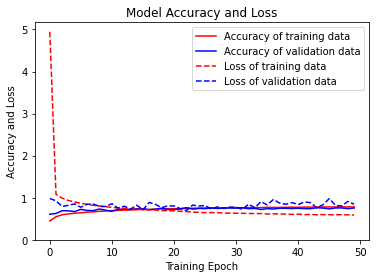

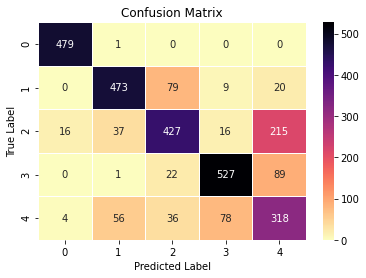

In [6]:
overlapPercents = [50]
# overlapPercents = [0]
# exclude_subjects = ['ddAeJA42PXvwthbW', 'nan', 'LLZjAPTyj7muHsEf',
#                     'MMuX9YIh4NTbLZLM', 'cbOZWnI7s1y8oLD4', 'PE8D53oX060qLbdX', 'xYdtS1F8tDyjEIgN', 'sUZBISq61Y7I5tqQ']
exclude_subjects = ['ddAeJA42PXvwthbW', 'nan', '0DXZFsYOfgqsYe0Z',
                    '0UXFxu10k0En1vDK',
                    'KNmC3LADpLyH5qJA',
                    'YbJVcb4vFFjKKlfe',
                    'ewpnQDEzR8hTqPRY', ]
for OVERLAP_PERCENT in overlapPercents:
    gpus = tf.config.list_logical_devices('GPU')
    strategy = tf.distribute.MirroredStrategy(gpus)
    with strategy.scope():
        X, y, subjects = get_overlap_data_all_sessions(OVERLAP_PERCENT)
        # REMOVE UNWANTED SUBJECTS
        indexes = np.where(subjects == exclude_subjects)
        X = np.delete(X, indexes[0], axis=0)
        y = np.delete(y, indexes[0], axis=0)
        subjects = np.delete(subjects, indexes[0], axis=0)
        # END REMOVE UNWANTED SUBJECTS

        # AUGMENT DATA
        resultant_acc = compute_resultant_acceleration(X)
        resultant_gyro = compute_resultant_gyro(X)
        resultant_angle = compute_resultant_angle(X)
        resultant_acc = resultant_acc.reshape(
            resultant_acc.shape[0], resultant_acc.shape[1], 1)
        resultant_gyro = resultant_gyro.reshape(
            resultant_gyro.shape[0], resultant_gyro.shape[1], 1)
        resultant_angle = resultant_angle.reshape(
            resultant_angle.shape[0], resultant_angle.shape[1], 1)
        X = np.concatenate((X, resultant_acc), axis=2)
        X = np.concatenate((X, resultant_gyro), axis=2)
        X = np.concatenate((X, resultant_angle), axis=2)
        # AUGMENT DATA END

        # print('UNIQUE subjects:', np.unique(subjects))
        X_train, X_test, y_train, y_test, y_train_non_encoded, y_test_non_encoded = split_test_train_by_subjects(
            X, y, subjects, train_percent=0.9)
        print('y_train shape', y_train.shape)
        X_train_stats = get_statistic_feature_all_channels(X_train)
        X_test_stats = get_statistic_feature_all_channels(X_test)
        print(X_train_stats.shape)

        model, history, evaluation_history = train_model_with_stats(
            X_train, y_train, X_test, y_test, X_train_stats, X_test_stats, overlap_percent=OVERLAP_PERCENT, batch_size=128, epochs=50)
        save_history(history, OVERLAP_PERCENT)
        save_test_history(evaluation_history, OVERLAP_PERCENT)
        save_accuracy_loss_figure(history, OVERLAP_PERCENT)
        validations, predictions = compute_validations_predictions_with_stats(
            model, X_test, y_test, X_test_stats)
        save_confusion_matrix_figure(
            validations, predictions, OVERLAP_PERCENT, sns)


In [7]:
def compute_validations_predictions_with_stats(model, X_test, y_test, X_test_stats):
    y_pred_test = model.predict([X_test, X_test_stats])
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(y_test, axis=1)

    return max_y_pred_test, max_y_test

In [8]:
validations, predictions = compute_validations_predictions_with_stats(
            model, X_test, y_test, X_test_stats)

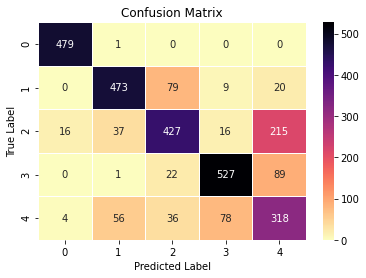

In [9]:
save_confusion_matrix_figure(
            validations, predictions, OVERLAP_PERCENT, sns)